In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('18100205.csv',header = 0)
#Check out data importing results
print(df.head())

  REF_DATE              GEO           DGUID New housing price indexes  \
0  1981-01           Canada  2016A000011124    Total (house and land)   
1  1981-01           Canada  2016A000011124                House only   
2  1981-01           Canada  2016A000011124                 Land only   
3  1981-01  Atlantic Region      2016A00011    Total (house and land)   
4  1981-01  Atlantic Region      2016A00011                House only   

                 UOM  UOM_ID SCALAR_FACTOR  SCALAR_ID      VECTOR  COORDINATE  \
0  Index, 201612=100     347        units           0  v111955442         1.1   
1  Index, 201612=100     347        units           0  v111955443         1.2   
2  Index, 201612=100     347        units           0  v111955444         1.3   
3  Index, 201612=100     347        units           0  v111955445         2.1   
4  Index, 201612=100     347        units           0  v111955446         2.2   

   VALUE STATUS  SYMBOL  TERMINATED  DECIMALS  
0   38.2    NaN     NaN   

In [3]:
#Check out data types
print(df.dtypes)
#Change REF_DATE into yyyy-mm date type
df['Month'] = pd.to_datetime(df.REF_DATE)

REF_DATE                      object
GEO                           object
DGUID                         object
New housing price indexes     object
UOM                           object
UOM_ID                         int64
SCALAR_FACTOR                 object
SCALAR_ID                      int64
VECTOR                        object
COORDINATE                   float64
VALUE                        float64
STATUS                        object
SYMBOL                       float64
TERMINATED                   float64
DECIMALS                       int64
dtype: object


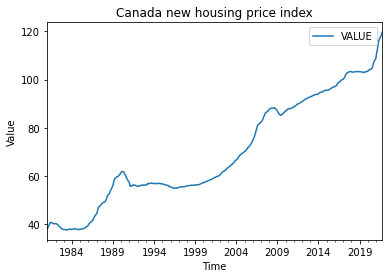

In [4]:
#Get data for all Canada
df_Can = df[(df.GEO == "Canada") & (df["New housing price indexes"].str.contains('Total'))]
#Plot data for all Canada
df_Can.plot(x = 'Month',y = 'VALUE')
plt.ylabel('Value')
plt.xlabel('Time')
plt.title('Canada new housing price index')
plt.show()

In [17]:
#Get table of metadata
df_md = pd.read_csv('18100205_MetaData.csv',header = 0, skiprows =7,nrows = 43)
print(df_md.columns)
print(df_md.describe())

Index(['Dimension ID', 'Member Name', 'Classification Code', 'Member ID',
       'Parent Member ID', 'Terminated', 'Member Notes', 'Member Definitions'],
      dtype='object')
       Dimension ID  Member ID  Parent Member ID  Terminated  Member Notes  \
count     43.000000  43.000000         41.000000         0.0      9.000000   
mean       1.069767  19.209302         15.073171         NaN      8.000000   
std        0.257770  12.234919         12.145761         NaN      2.738613   
min        1.000000   1.000000          1.000000         NaN      4.000000   
25%        1.000000   8.500000          2.000000         NaN      6.000000   
50%        1.000000  19.000000         17.000000         NaN      8.000000   
75%        1.000000  29.500000         28.000000         NaN     10.000000   
max        2.000000  40.000000         37.000000         NaN     12.000000   

       Member Definitions  
count                 0.0  
mean                  NaN  
std                   NaN  
min      

In [16]:
unique_province_id = df_md['Parent Member ID'].unique()
print(unique_province_id)

provinces_names = df_md[(df_md['Member ID'].isin(unique_province_id)) & (df_md['Dimension ID']==1) \
    & ~(df_md['Member ID'].isin([1,2,28]))]['Member Name']
print(provinces_names)

[nan  1.  2.  3.  5.  7.  9. 11. 17. 28. 29. 31. 34. 37.]
2     Newfoundland and Labrador
4          Prince Edward Island
6                   Nova Scotia
8                 New Brunswick
10                       Quebec
16                      Ontario
28                     Manitoba
30                 Saskatchewan
33                      Alberta
36             British Columbia
Name: Member Name, dtype: object


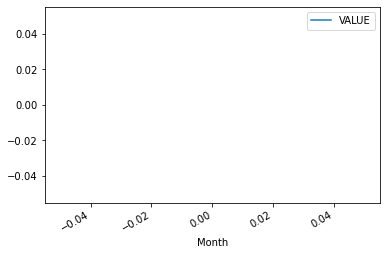

In [18]:
province_df = {}
for name in provinces_names:
    province_df[name] = df[df.GEO == name]



    REF_DATE     GEO        DGUID New housing price indexes  \
30   1981-01  Quebec  2016A000224    Total (house and land)   
150  1981-02  Quebec  2016A000224    Total (house and land)   
270  1981-03  Quebec  2016A000224    Total (house and land)   
390  1981-04  Quebec  2016A000224    Total (house and land)   
510  1981-05  Quebec  2016A000224    Total (house and land)   

                   UOM  UOM_ID SCALAR_FACTOR  SCALAR_ID      VECTOR  \
30   Index, 201612=100     347        units           0  v111955472   
150  Index, 201612=100     347        units           0  v111955472   
270  Index, 201612=100     347        units           0  v111955472   
390  Index, 201612=100     347        units           0  v111955472   
510  Index, 201612=100     347        units           0  v111955472   

     COORDINATE  VALUE STATUS  SYMBOL  TERMINATED  DECIMALS      Month  
30         11.1    NaN     ..     NaN         NaN         1 1981-01-01  
150        11.1    NaN     ..     NaN         Na

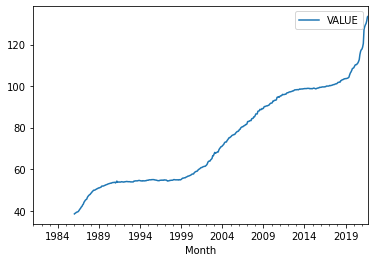

In [26]:
temp_province = province_df['Quebec']
temp_province = temp_province[temp_province["New housing price indexes"].str.contains('Total')].\
    dropna(axis = 0, subset = ['Month'])
print(temp_province.head())
temp_province.plot(x = 'Month',y = 'VALUE')
plt.show()